In [1]:
from biodatatools.utils.common import json_load
import pandas as pd
import scipy.cluster.hierarchy as sch
import matplotlib.colors as mcolors
from sklearn.decomposition import PCA
from biodata.delimited import DelimitedWriter
import itertools
from mphelper import ProcessWrapPool
from collections import defaultdict
import seaborn as sns
from scipy.stats import zscore
from matplotlib.patches import Patch
import statsmodels.api as sm
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt
import sys

In [2]:
font_dir = Path.cwd().parent / "font"
for font in ["Arial.ttf", "Arial_Bold.ttf"]:
    matplotlib.font_manager.fontManager.addfont(font_dir / font)
matplotlib.rcParams["font.family"] = "Arial"
bfontsize = 12
sfontsize = 9
lw = 0.8

In [5]:
PROJECT_DIR_d = "/home/yc2553/projects/HEA/databases/"
PROJECT_DIR_o = "/home/yc2553/projects/HEA/output/"

In [3]:
PROJECT_DIR_s = "/home/yc2553/softwares/radialtree/"
sys.path.append(PROJECT_DIR_s)
# We’ve modified the source code to suppress printing of intermediate values...
import radialtree2 as rt

# Clustering

In [4]:
ps = ["divergent", "unidirectional"]
ds = ["distal", "proximal"]

In [7]:
labels = json_load(f"{PROJECT_DIR_d}PROcap/metainfo/classifications.json")

In [8]:
metafile = f"{PROJECT_DIR_o}tables/SuppTable1.xlsx"
df_metrics = pd.read_excel(metafile, sheet_name=2)
reads = {}
for _, row in df_metrics.iterrows():
    reads[row["PRO-cap sample ID"]] = row["Uniquely mapped, deduplicated read pairs"]

In [9]:
all_samples = json_load(f"{PROJECT_DIR_d}PROcap/metainfo/samples.json")["normal_tissues"]
samples = [s for s in all_samples if reads[s] >= 10e6]
len(samples)

128

In [10]:
df_exp = pd.read_table(f"{PROJECT_DIR_d}PROcap/processed/norm_reads_vst_all.txt", index_col=0)
dfs = {}
for p, d in itertools.product(ps, ds):
    # Only keep elements found in these samples
    df_binary = pd.read_table(f"{PROJECT_DIR_d}PROcap/processed/binary_{p}_{d}.txt", index_col=0)
    es = list(df_binary[df_binary[samples].sum(axis=1) >= 1].index)
    dfs[(p,d)] = df_exp[samples].loc[es]

In [23]:
cdict = json_load(f"{PROJECT_DIR_d}PROcap/metainfo/color_codes.json")
cdict["Other"] = "#f0f0f0"
ts, colors = zip(*cdict.items())

In [13]:
tissue_labels = []
# Outliers are not highlighted
excluded = ["HN3", "GT29"]
for s in samples:
    if labels[s][1] in ts[:-1] and s not in excluded:
        tissue_labels.append(labels[s][1])
    else:
        tissue_labels.append("Other")

In [14]:
# Convert to an RGB color
cdict_rgb = dict(zip(ts, [mcolors.to_rgb(c) for c in colors]))
colorlabels = {"Tissue type": [cdict_rgb[s] for s in tissue_labels]}
colorlabels_legend = {"colors": colors, "labels": ts}

In [15]:
# https://github.com/koonimaru/radialtree

def cluster(df, labels, colorlabels, outputfile, figsize, colorlabels_legend=None, addlabels=True):
    pca = PCA(n_components=0.9, random_state=42)
    data = pca.fit_transform(df)
    linkage = sch.linkage(data, metric='euclidean', method='ward')
    dendrogram = sch.dendrogram(linkage, labels=[f"{labels[s][0]} ({s})" for s in samples], no_plot=True, color_threshold=0.1)
    g = rt.plot(dendrogram, figsize=figsize, fontsize=4, 
                addlabels=addlabels, show=False,
                colorlabels=colorlabels
               )
    if colorlabels_legend:
        handles = [
            Patch(color=c, label=l)
            for c, l in zip(colorlabels_legend["colors"],
                            colorlabels_legend["labels"])
            ]
        g.legend(
            handles=handles,
            title="",
            ncol=2,
            fontsize=sfontsize,
            labelspacing=0.8,
            handlelength=1,
            loc='upper left',
            frameon=False,
            bbox_to_anchor=(1.05, 0.97)
            )
    plt.savefig(outputfile, bbox_inches="tight", transparent=True)

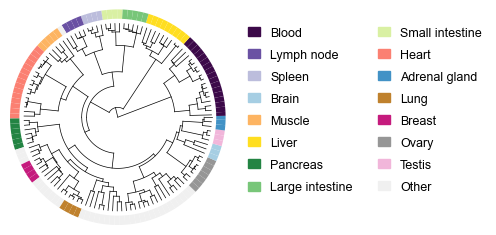

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


In [22]:
# Main figure

p = "divergent"
d = "distal"
outputfile = f"{PROJECT_DIR_o}figures/Fig2a.pdf"
cluster(dfs[(p,d)].T, labels, colorlabels, outputfile, (4.8,2.8), colorlabels_legend, False)

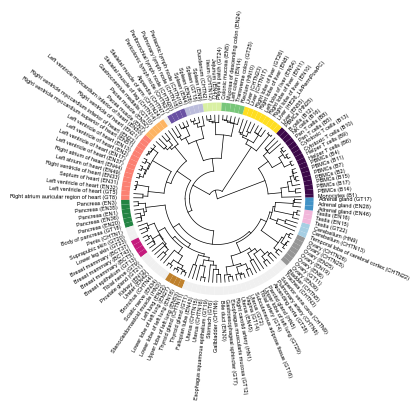

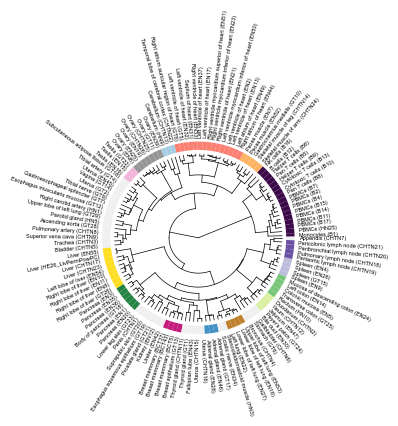

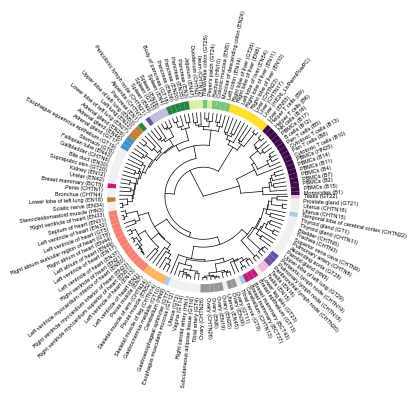

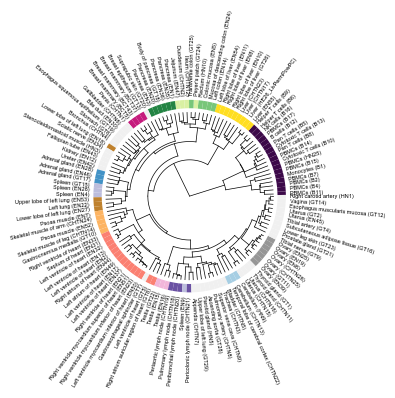

In [16]:
# SuppFigs: show labels for all categories

for p, d in itertools.product(ps, ds):
    if d == "distal":
        figN = "a" if p == "divergent" else "b"
    else:
        figN = "c" if p == "divergent" else "d"
    outputfile = f"{PROJECT_DIR_o}figures/SuppFig2{figN}.pdf"
    cluster(dfs[(p,d)].T, labels, colorlabels, outputfile, (2.7,2.5))

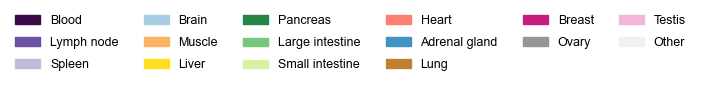

In [20]:
# Generate a legend for suppFigs

fig, ax = plt.subplots(figsize=(2,1))
handles = [
            Patch(color=c, label=l)
            for c, l in zip(colorlabels_legend["colors"],
                            colorlabels_legend["labels"])
            ]
ax.legend(
    handles=handles,
    fontsize=sfontsize,
    ncols=6,
    labelspacing=0.8,
    loc='upper left',
    bbox_to_anchor=(0, 1),
    borderaxespad=0.,
    frameon=False
    )
ax.axis('off')
plt.savefig(f"{PROJECT_DIR_o}figures/SuppFig2.legend.pdf", bbox_inches="tight")

# Specifically expressed TREs

In [25]:
# For a bunch of downstream analysis, we mainly focus on tissue types with at least three samples

samples_keep = [s for s in samples if labels[s][1] in ts[:-1] and s not in excluded]
len(samples_keep)

93

In [54]:
outputfile = f"{PROJECT_DIR_d}PROcap/metainfo/keep_samples.txt"
with DelimitedWriter(outputfile) as dw:
	for s in samples_keep:
		dw.write([s])

In [26]:
def tstats_one_group(samples, df, labels, group, outputfile):
	import pandas as pd
	
	data = {"X1": [1 if labels[s][1] == group else -1 for s in samples]}
	results = []
	for i, row in df.iterrows():
		data["Y"] = [row[s] for s in samples]
		results.append([tstats_one_element(data)])
	df2 = pd.DataFrame(results, index=df.index, columns=["tstats"])
	df2 = df2.sort_values(by="tstats", ascending=False)
	df2.to_csv(outputfile, sep="\t")

In [79]:
pwpool = ProcessWrapPool(10)

p = "divergent"
for d, t in itertools.product(ds, ts[:-1]):
	df = pd.read_table(f"{PROJECT_DIR_d}PROcap/processed/binary_{p}_{d}.txt", index_col=0)
	es = list(df[df[samples_keep].sum(axis=1) >= 1].index)
	df = df[samples_keep].loc[es]
	t2 = "_".join(t.split(" "))
	outputfile = f"{PROJECT_DIR_d}PROcap/processed/tstats_{p}_{d}_{t2}.txt"
	pwpool.run(tstats_one_group, args=[samples_keep, df, labels, t, outputfile])

In [89]:
len(pwpool.finished_tasks)

60

In [90]:
pwpool.close()

In [29]:
# Keep top 5% most specifically expressed elements
# Focus on divergent elements for visualization

cutoff = 0.05
tres = defaultdict(dict)
for d, t in itertools.product(ds, ts[:-1]):
	t2 = "_".join(t.split(" "))
	df = pd.read_table(f"{PROJECT_DIR_d}PROcap/processed/tstats_{p}_{d}_{t2}.txt", index_col=0)
	top = int(cutoff * len(df))
	tres[(p,d)][t] = list(df["tstats"].nlargest(top).index)

In [30]:
# Get the union set of specifically expressed TREs
# Sort TREs in a way that tissue-specific expression blocks are displayed in the diagonal line
# TREs shared by multiple tissue types were displayed only once in the heatmap, in the first tissue type where they appeared.

df_select = {}
for k in tres:
	top_tres = []
	for t in tres[k]:
		top_tres.extend([e for e in tres[k][t] if e not in set(top_tres)])
	df_select[k] = dfs[k].loc[top_tres][samples_keep]
	print(k, len(df_select[k]))

('divergent', 'distal') 101472
('divergent', 'proximal') 31257


In [31]:
# Display samples in the order of tissue types

order = []
for t in ts[:-1]:
	order.extend([s for s in samples_keep if labels[s][1] == t])

In [32]:
# Use Z-score to highlight the tissue-specific expression blocks
# row: samples
# column: elements

df_zscore = {}
for k in df_select:
	df_zscore[k] = df_select[k][order].apply(zscore, axis=1).T

In [33]:
# Map the sample labels to corresponding colors

color_vectors = pd.DataFrame([cdict[labels[s][1]] for s in order], index=order)
color_vectors.columns = [""]
color_vectors.head(2)

,
B1,#3C0949
B10,#3C0949


In [34]:
palette = sns.color_palette(cdict.values()[:-1])

In [35]:
# Get the last row index for each color zone to plot the horizontal lines

lst = list(color_vectors[""])
last_indices = [len(lst) - 1 - lst[::-1].index(value) for value in set(lst)] 
last_indices

[52, 89, 56, 41, 27, 92, 78, 82, 20, 47, 74, 16, 24, 32, 71]

In [61]:
def heatmap(df, k, subtypes, color_vectors, palette, outputfile, legend=True, vlims=[-3,0,3]):
	g = sns.clustermap(data=df, cmap="bwr", 
					  xticklabels=False, yticklabels=False, 
					  row_cluster=False, col_cluster=False,
					  row_colors=color_vectors, figsize=(3.5,3),
					  vmin=vlims[0], vmax=vlims[-1],
					  dendrogram_ratio=(0,0.01))	
	
	for n in last_indices:
		g.ax_heatmap.axhline(y=n+1, color="black", linewidth=1)
		
	for label in subtypes:
		i = subtypes.index(label)
		g.ax_row_dendrogram.bar(0, 0, color=palette[i],
								label=label,
								linewidth=0)

	if legend:
		g.ax_row_dendrogram.legend(fontsize=sfontsize, bbox_to_anchor=(-0.45,0.95), loc="upper left", frameon=False, bbox_transform=plt.gcf().transFigure)	

	g.cax.set_visible(False)
	cbar_ax = g.fig.add_axes([0.5, 1.02, 0.2, 0.03])
	cbar = plt.colorbar(g.ax_heatmap.collections[0], cax=cbar_ax, orientation="horizontal")
	cbar.ax.text(-0.5, -0.1, "Z-score", fontsize=sfontsize, 
				 ha='center', va='bottom', transform=cbar.ax.transAxes)
	cbar.set_ticks(vlims)
	cbar.set_ticklabels([str(v) for v in vlims])
	cbar.ax.tick_params(labelsize=sfontsize) 
		
	n_samples, n_TREs = df.shape
	g.ax_heatmap.text(-0.05, 0.7, f"{n_samples} samples", fontsize=bfontsize, rotation=90, 
					  ha='right', va='bottom', transform=g.ax_heatmap.transAxes)
	g.ax_heatmap.annotate("", xy=(-0.07, 0.45), xytext=(-0.07, 0.65),
						arrowprops=dict(facecolor="#000000", shrink=0.05, width=1, headwidth=5),
						xycoords='axes fraction')
	
	g.ax_heatmap.text(0, -0.02, f"{n_TREs:,.0f} {k[0]} {k[1]} TREs", fontsize=bfontsize, 
                  ha='left', va='top', transform=g.ax_heatmap.transAxes)
	if k[1] == "distal":
		x1 = 0.95
		x2 = 0.75
	else:
		x1 = 1
		x2 = 0.8
	g.ax_heatmap.annotate("", xy=(x1, -0.05), xytext=(x2, -0.05),
							arrowprops=dict(facecolor="#000000", shrink=0.05, width=1, headwidth=5),
							xycoords='axes fraction')
	
	plt.savefig(outputfile, bbox_inches="tight", dpi=300, transparent=True)

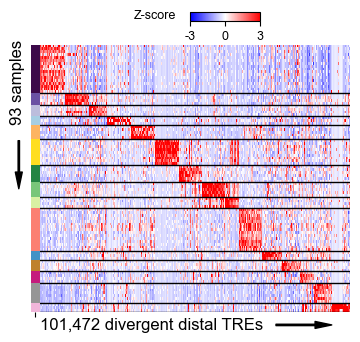

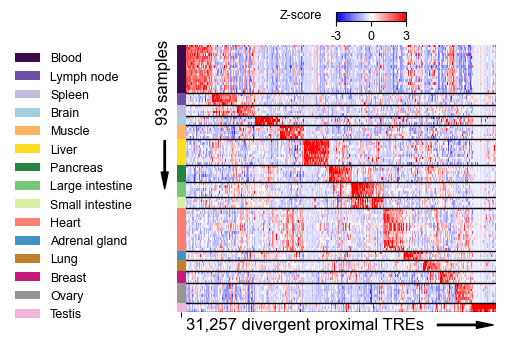

In [63]:
for d in ds:
	if d == "distal":
		outputfile = f"{PROJECT_DIR_o}figures/Fig2d.png"
	else:
		outputfile = f"{PROJECT_DIR_o}figures/ExtDataFig3c.png"
	legend = False if d == "distal" else True
	heatmap(df_zscore[(p,d)], (p,d), list(cdict.keys()), color_vectors, palette, outputfile, legend)